# Evaluation of multi-class drift detection

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from scipy.io import arff

from river import compose
from river import linear_model
from river import metrics
from river import multioutput
from river import preprocessing
from river import tree
from river.naive_bayes import GaussianNB
from tqdm import tqdm
from river.drift import ADWIN
from river.metrics import Accuracy
import matplotlib.pyplot as plt
import numpy as np

from river.drift import MLABEL

from river.drift import KSWIN

### MLABEL example usage

In [2]:
import random
from river.drift import MLABEL

stream = []

# Label 1: mostly 0 before drift, mostly 1 after drift
for _ in range(500):
  stream.append([0, random.choices([0, 1], weights=[0.9, 0.1])[0], 1])
for _ in range(500):
  stream.append([0, random.choices([0, 1], weights=[0.1, 0.9])[0], 1])

mlabel = MLABEL()

for i, y in enumerate(stream):
  mlabel.update(y)
  for label, drift in mlabel.drift_detected.items():
    if drift:
      print(f"Drift detected on label {label} at index {i}")

Drift detected on label 1 at index 543


## Utils for evaluation

In [67]:
# Main function: simulates the stream processing and calculates accuracy and kappa
def run_stream(df, target_cols, base_clf=tree.HoeffdingTreeClassifier(), window=50):
    window_accuracies = []
    ks_window_accuracies = []
    ml_window_accuracies = []
    window_kappa = []
    ks_window_kappa = []
    ml_window_kappa = []

    model = multioutput.ClassifierChain(base_clf)
    kswin_model = multioutput.ClassifierChain(base_clf)
    mlabel_model = multioutput.ClassifierChain(base_clf)

    full_accuracy = metrics.F1()
    ks_full_accuracy = metrics.F1()
    ml_full_accuracy = metrics.F1()

    full_kappa = metrics.CohenKappa()
    ks_full_kappa = metrics.CohenKappa()
    ml_full_kappa = metrics.CohenKappa()

    mlabel_detector = MLABEL()
    adwin_detector = ADWIN()
    kswin_detector = KSWIN()

    adwin_drift_points = []
    kswin_drift_points = []
    mlabel_drift_points = { i: [] for i, label in enumerate(target_cols) }

    N = len(df)

    for i, row in tqdm(df.iterrows(), total=N, desc="Streaming"):
        X = row.drop(labels=target_cols).to_dict()
        y = row[target_cols].astype(int).to_dict()

        # Models predict and update
        y_pred = model.predict_one(X)
        model.learn_one(X, y)

        ks_y_pred = kswin_model.predict_one(X)
        kswin_model.learn_one(X, y)

        ml_y_pred = mlabel_model.predict_one(X)
        mlabel_model.learn_one(X, y)

        # Metrics update
        for label in target_cols:
            full_accuracy.update(y[label], y_pred.get(label, 0))
            ks_full_accuracy.update(y[label], ks_y_pred.get(label, 0))
            ml_full_accuracy.update(y[label], ml_y_pred.get(label, 0))


            full_kappa.update(y[label], y_pred.get(label, 0))
            ks_full_kappa.update(y[label], ks_y_pred.get(label, 0))
            ml_full_kappa.update(y[label], ml_y_pred.get(label, 0))

        if (i + 1) % window == 0:
            window_accuracies.append(full_accuracy.get())
            ks_window_accuracies.append(ks_full_accuracy.get())
            ml_window_accuracies.append(ml_full_accuracy.get())
            window_kappa.append(full_kappa.get())
            ks_window_kappa.append(ks_full_kappa.get())
            ml_window_kappa.append(ml_full_kappa.get())

        # ADWIN
        y_true_str = ''.join(map(str, row[target_cols].astype(int).values))
        y_pred_str = ''.join(['1' if v else '0' for v in y_pred.values()])
        adwin_detector.update(int(y_true_str == y_pred_str))
        if adwin_detector.drift_detected:
            adwin_drift_points.append(i)
            model = multioutput.ClassifierChain(base_clf)
            full_accuracy = Accuracy()
            full_kappa = metrics.CohenKappa()

        # KSWIN
        y_true_str = ''.join(map(str, row[target_cols].astype(int).values))
        y_pred_str = ''.join(['1' if v else '0' for v in ks_y_pred.values()])
        kswin_detector.update(int(y_true_str == y_pred_str))
        if kswin_detector.drift_detected:
            kswin_drift_points.append(i)
            kswin_model = multioutput.ClassifierChain(base_clf)
            ks_full_accuracy = Accuracy()
            ks_full_kappa = metrics.CohenKappa()

        # MLABEL
        # y_true = row[target_cols].astype(int).values
        # erorrs = [int(x != y) for x, y in zip(y_true, ml_y_pred)]
        # mlabel_detector.update(erorrs) # passing errors instead of true labels results in no drift detection
        mlabel_detector.update(row[target_cols].astype(int).values)
        for label, drift in mlabel_detector.drift_detected.items():
            if drift:
                mlabel_drift_points[label].append(i)
                mlabel_model = multioutput.ClassifierChain(base_clf)
                ml_full_accuracy = Accuracy()
                ml_full_kappa = metrics.CohenKappa()
    
    return {
        "window_accuracies": window_accuracies,
        "ks_window_accuracies": ks_window_accuracies,
        "ml_window_accuracies": ml_window_accuracies,
        "window_kappa": window_kappa,
        "ks_window_kappa": ks_window_kappa,
        "ml_window_kappa": ml_window_kappa,
        "adwin_drift_points": adwin_drift_points,
        "kswin_drift_points": kswin_drift_points,
        "mlabel_drift_points": mlabel_drift_points
    }


In [68]:
# Main function: simulates the stream processing and calculates accuracy and kappa
def run_rcv1_stream(rcv1, target_cols, base_clf=tree.HoeffdingTreeClassifier(), window=50):
    window_accuracies = []
    ks_window_accuracies = []
    ml_window_accuracies = []
    window_kappa = []
    ks_window_kappa = []
    ml_window_kappa = []

    model = multioutput.ClassifierChain(base_clf)
    kswin_model = multioutput.ClassifierChain(base_clf)
    mlabel_model = multioutput.ClassifierChain(base_clf)

    full_accuracy = metrics.F1()
    ks_full_accuracy = metrics.F1()
    ml_full_accuracy = metrics.F1()

    full_kappa = metrics.CohenKappa()
    ks_full_kappa = metrics.CohenKappa()
    ml_full_kappa = metrics.CohenKappa()

    mlabel_detector = MLABEL()
    adwin_detector = ADWIN()
    kswin_detector = KSWIN()

    adwin_drift_points = []
    kswin_drift_points = []
    mlabel_drift_points = { i: [] for i, label in enumerate(target_cols) }

    N = rcv1.data.shape[0]

    for i in tqdm(range(rcv1.data.shape[0]), total=N, desc="Streaming"):
        X = rcv1.data.getrow(i)
        y = rcv1.target[i] 
        X_dense = X.toarray().ravel()
        y_dense = y.toarray().ravel()
        X_dict = {j: X_dense[j] for j in range(len(X_dense)) if X_dense[j] != 0}
        y_dict = {idx: int(val) for idx, val in enumerate(y_dense) if val != 0}
        # X = row.drop(labels=target_cols).to_dict()
        # y = row[target_cols].astype(int).to_dict()

        # Models predict and update
        y_pred = model.predict_one(X_dict)
        model.learn_one(X_dict, y_dict)

        ks_y_pred = kswin_model.predict_one(X_dict)
        kswin_model.learn_one(X_dict, y_dict)

        ml_y_pred = mlabel_model.predict_one(X_dict)
        mlabel_model.learn_one(X_dict, y_dict)

        # Metrics update
        for label in target_cols:
            full_accuracy.update(y_dense[label], y_pred.get(label, 0))
            ks_full_accuracy.update(y_dense[label], ks_y_pred.get(label, 0))
            ml_full_accuracy.update(y_dense[label], ml_y_pred.get(label, 0))
            full_kappa.update(y_dense[label], y_pred.get(label, 0))
            ks_full_kappa.update(y_dense[label], ks_y_pred.get(label, 0))
            ml_full_kappa.update(y_dense[label], ml_y_pred.get(label, 0))

        if (i + 1) % window == 0:
            window_accuracies.append(full_accuracy.get())
            ks_window_accuracies.append(ks_full_accuracy.get())
            ml_window_accuracies.append(ml_full_accuracy.get())
            window_kappa.append(full_kappa.get())
            ks_window_kappa.append(ks_full_kappa.get())
            ml_window_kappa.append(ml_full_kappa.get())

        # ADWIN
        y_true_str = ''.join(map(str, y_dense))
        y_pred_str = ''.join(['1' if v else '0' for v in y_pred.values()])
        adwin_detector.update(int(y_true_str == y_pred_str))
        if adwin_detector.drift_detected:
            adwin_drift_points.append(i)
            model = multioutput.ClassifierChain(base_clf)
            full_accuracy = Accuracy()
            full_kappa = metrics.CohenKappa()

        # KSWIN
        y_true_str = ''.join(map(str, y_dense))
        y_pred_str = ''.join(['1' if v else '0' for v in ks_y_pred.values()])
        kswin_detector.update(int(y_true_str == y_pred_str))
        if kswin_detector.drift_detected:
            kswin_drift_points.append(i)
            kswin_model = multioutput.ClassifierChain(base_clf)
            ks_full_accuracy = Accuracy()
            ks_full_kappa = metrics.CohenKappa()

        # MLABEL
        mlabel_detector.update(y_dict)
        for label, drift in mlabel_detector.drift_detected.items():
            if drift:
                mlabel_drift_points[label].append(i)
                mlabel_model = multioutput.ClassifierChain(base_clf)
                ml_full_accuracy = Accuracy()
                ml_full_kappa = metrics.CohenKappa()
    
    return {
        "window_accuracies": window_accuracies,
        "ks_window_accuracies": ks_window_accuracies,
        "ml_window_accuracies": ml_window_accuracies,
        "window_kappa": window_kappa,
        "ks_window_kappa": ks_window_kappa,
        "ml_window_kappa": ml_window_kappa,
        "adwin_drift_points": adwin_drift_points,
        "kswin_drift_points": kswin_drift_points,
        "mlabel_drift_points": mlabel_drift_points
    }

In [12]:
# Plotting results
def plot_results(results, N, target_cols, window = 50, show_drift=True):
    # Accuracy
    plt.plot(range(window, N + 1, window), results["window_accuracies"], label='ADWIN F1 Score')
    plt.plot(range(window, N + 1, window), results["ml_window_accuracies"], label='MLABEL F1 Score')
    plt.plot(range(window, N + 1, window), results["ks_window_accuracies"], label='KSWIN F1 Score')
    if (show_drift):
        for i, label in enumerate(target_cols):
            for drift in results["mlabel_drift_points"][i]:
                plt.axvline(x=drift, color='pink', linestyle='--', label=f'MLABEL drift' if i == 0 else "")

        for i, drift in enumerate(results["adwin_drift_points"]):
            plt.axvline(x=drift, color='gray', linestyle=':', label='ADWIN drift' if i == 0 else "")
        for i, drift in enumerate(results["kswin_drift_points"]):
            plt.axvline(x=drift, color='lightgreen', linestyle='-.', label='KSWIN drift' if i == 0 else "")
    plt.ylim(top=1)
    plt.legend(loc='upper right')
    plt.title('Drift detection comparison')
    plt.ylabel('F1 Score')
    plt.xlabel('Instance ID')
    plt.show()

    # Kappa
    plt.plot(range(window, N + 1, window), results["window_kappa"], label='Adwin Kappa')
    plt.plot(range(window, N + 1, window), results["ml_window_kappa"], label='MLABEL Kappa')
    plt.plot(range(window, N + 1, window), results["ks_window_kappa"], label='KSWIN Kappa')
    if (show_drift):
        for i, label in enumerate(target_cols):
            for drift in results["mlabel_drift_points"][i]:
                plt.axvline(x=drift, color='pink', linestyle='--', label=f'MLABEL drift' if i == 0 else "")

        for i, drift in enumerate(results["adwin_drift_points"]):
            plt.axvline(x=drift, color='gray', linestyle=':', label='ADWIN drift' if i == 0 else "")
        for i, drift in enumerate(results["kswin_drift_points"]):
            plt.axvline(x=drift, color='lightgreen', linestyle='-.', label='KSWIN drift' if i == 0 else "")
    plt.ylim(top=1)
    plt.legend(loc='upper right')
    plt.title('Drift detection comparison')
    plt.ylabel('Metric value')
    plt.xlabel('Instance ID')
    plt.show()

### Sudden drift (simulated data)

Streaming: 100%|██████████| 100000/100000 [14:16<00:00, 116.73it/s]


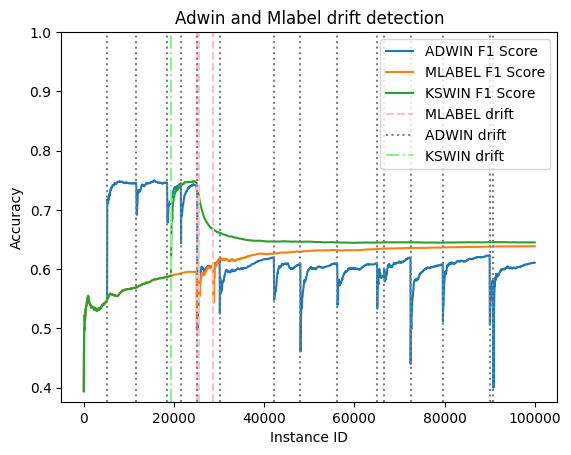

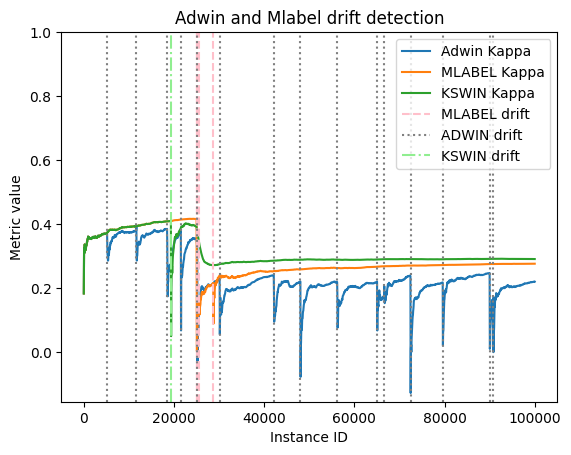

In [73]:
data, meta = arff.loadarff('./data/rt_sudden_balanced.arff')

df = pd.DataFrame(data)
df = df.map(lambda x: x.decode() if isinstance(x, bytes) else x)
target_cols = ['class0', 'class1', 'class2', 'class3', 'class4']
df[target_cols] = df[target_cols].astype(int)
df.head()
N = len(df)
window = 50

results = run_stream(df, target_cols, window=window)
plot_results(results, N, target_cols, window)

### Gradual drift (generated)

Streaming: 100%|██████████| 100000/100000 [14:10<00:00, 117.61it/s]


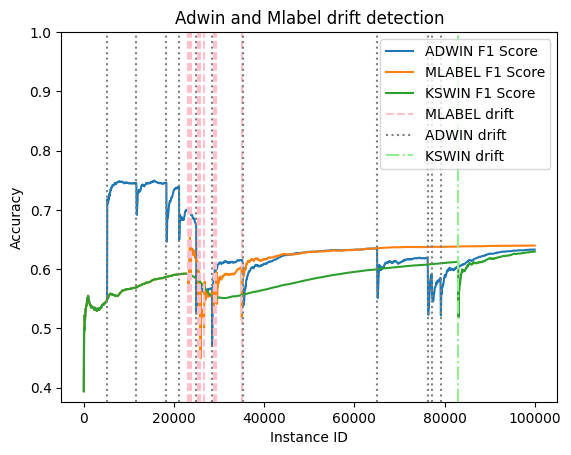

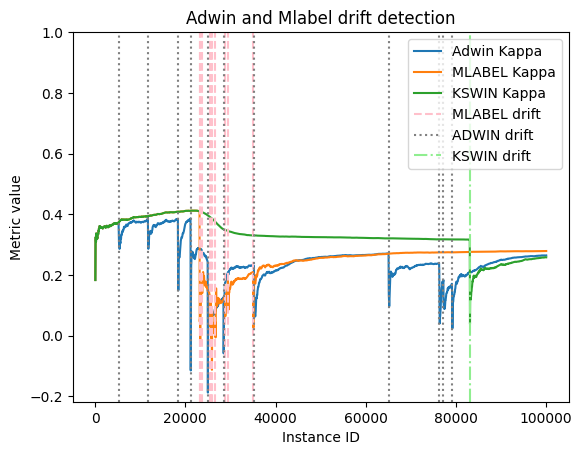

In [74]:
data, meta = arff.loadarff('./data/rt_gradual_balanced.arff')

df = pd.DataFrame(data)
df = df.map(lambda x: x.decode() if isinstance(x, bytes) else x)
target_cols = ['class0', 'class1', 'class2', 'class3', 'class4']
df[target_cols] = df[target_cols].astype(int)
df.head()
N = len(df)
window = 50

results = run_stream(df, target_cols, window=window)
plot_results(results, N, target_cols, window)

### Incremental and sudden drift (generated)

Streaming: 100%|██████████| 100000/100000 [13:39<00:00, 121.97it/s]


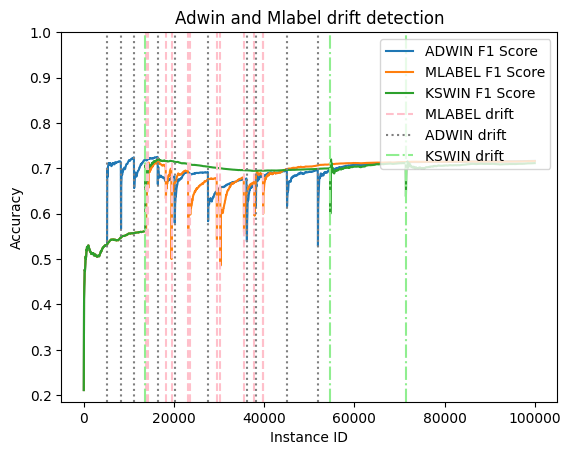

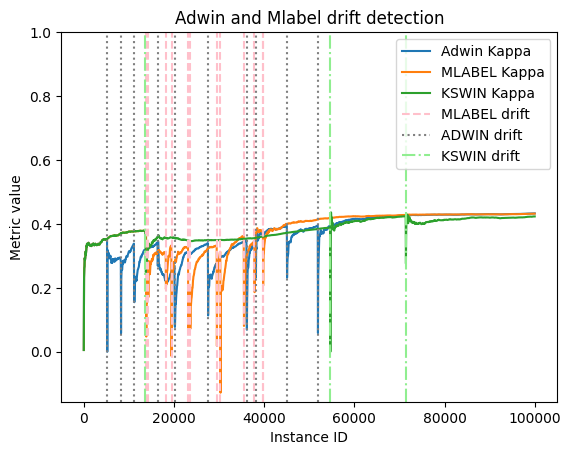

In [75]:
data, meta = arff.loadarff('./data/rt_incremental_sudden_balanced.arff')

df = pd.DataFrame(data)
df = df.map(lambda x: x.decode() if isinstance(x, bytes) else x)
target_cols = ['class0', 'class1', 'class2', 'class3', 'class4']
df[target_cols] = df[target_cols].astype(int)
df.head()
N = len(df)
window = 50

results = run_stream(df, target_cols, window=window)
plot_results(results, N, target_cols, window)

### RCV1 (real dataset)

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_rcv1.html

In [76]:
from sklearn.datasets import fetch_rcv1

rcv1 = fetch_rcv1(subset='train')
rcv1.data.shape

(23149, 47236)

Streaming: 100%|██████████| 23149/23149 [15:40<00:00, 24.62it/s]


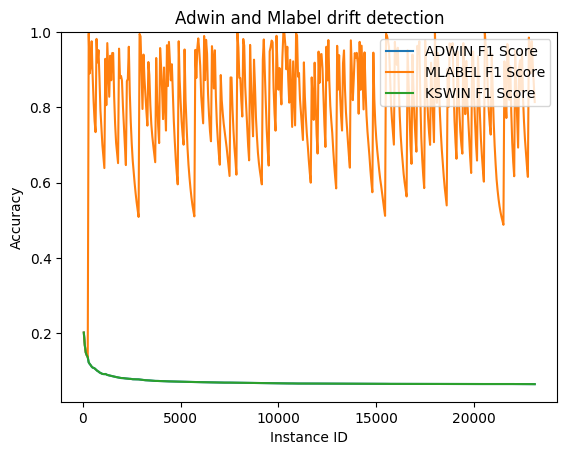

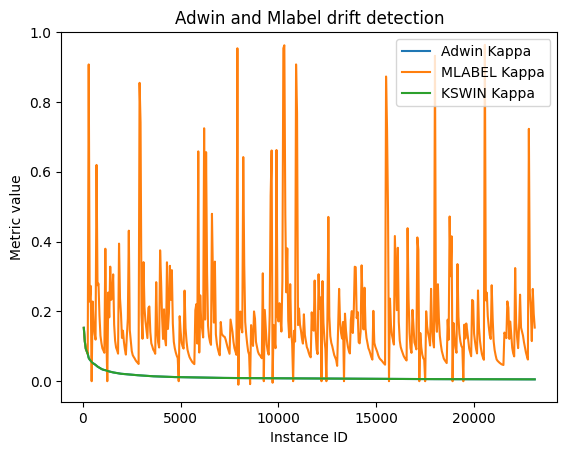

In [77]:
target_cols = [i for i in range(rcv1.target.shape[1])]
results = run_rcv1_stream(rcv1, target_cols)
plot_results(results, rcv1.data.shape[0], target_cols, window=window, show_drift=False)

Streaming: 100%|██████████| 804414/804414 [23:58:35<00:00,  9.32it/s]       


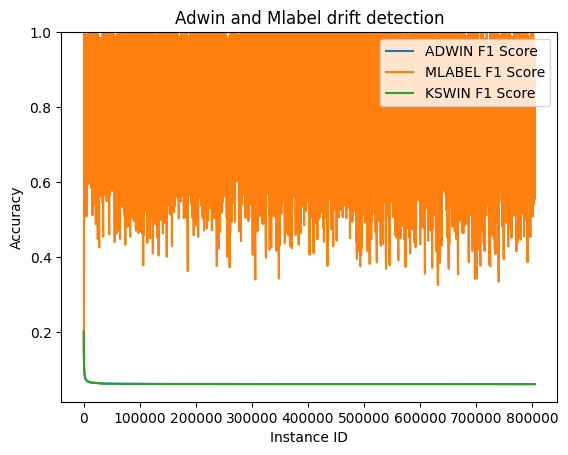

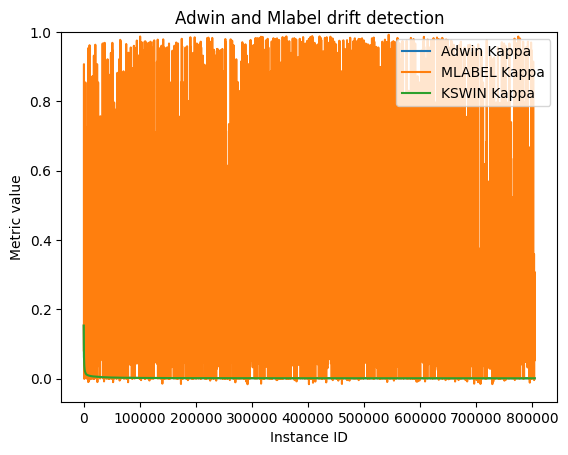

In [78]:
# Full RCV1
rcv1 = fetch_rcv1()
target_cols = [i for i in range(rcv1.target.shape[1])]
results = run_rcv1_stream(rcv1, target_cols)
plot_results(results, rcv1.data.shape[0], target_cols, window=window, show_drift=False)

In [87]:
window_size = 10000  # You can tweak this number
cumsum = np.cumsum(np.insert(results['ml_window_accuracies'], 0, 0)) 
smoothed = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
len(smoothed)

6089

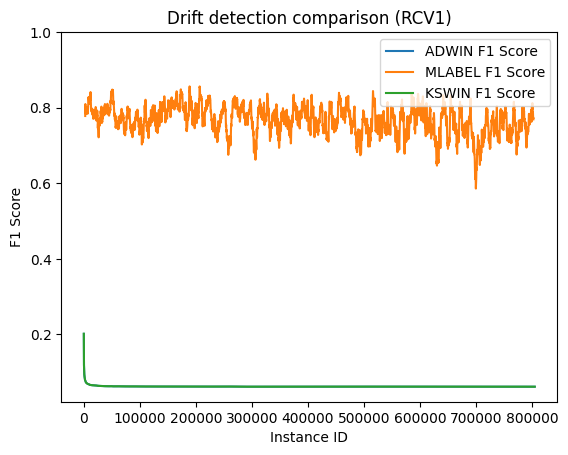

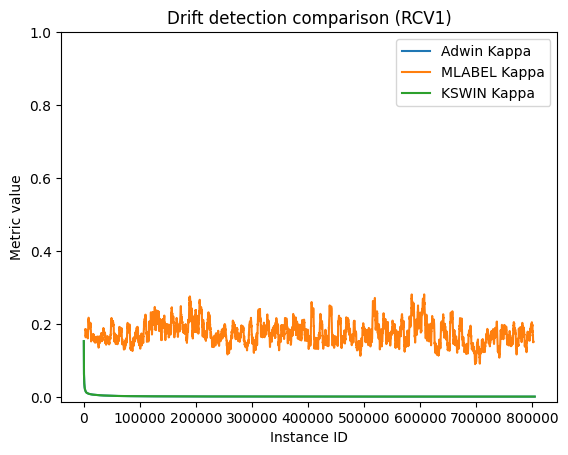

In [107]:
def plot_results_new(results, N, target_cols, window = 50, show_drift=True):
    # Accuracy
    x_sampled = np.arange(window, N+1, window)
    smooth_window = 100
    smoothed = np.convolve(results['ml_window_accuracies'], np.ones(smooth_window)/smooth_window, mode='valid')
    x_smoothed = x_sampled[smooth_window//2 : len(x_sampled) - smooth_window//2 + 1]

    plt.plot(range(window, N + 1, window), results["window_accuracies"], label='ADWIN F1 Score')
    plt.plot(x_smoothed, smoothed, label='MLABEL F1 Score')
    plt.plot(range(window, N + 1, window), results["ks_window_accuracies"], label='KSWIN F1 Score')
    if (show_drift):
        for i, label in enumerate(target_cols):
            for drift in results["mlabel_drift_points"][i]:
                plt.axvline(x=drift, color='pink', linestyle='--', label=f'MLABEL drift' if i == 0 else "")

        for i, drift in enumerate(results["adwin_drift_points"]):
            plt.axvline(x=drift, color='gray', linestyle=':', label='ADWIN drift' if i == 0 else "")
        for i, drift in enumerate(results["kswin_drift_points"]):
            plt.axvline(x=drift, color='lightgreen', linestyle='-.', label='KSWIN drift' if i == 0 else "")
    plt.ylim(top=1)
    plt.legend(loc='upper right')
    plt.title('Drift detection comparison (RCV1)')
    plt.ylabel('F1 Score')
    plt.xlabel('Instance ID')
    plt.show()

    # Kappa
    x_sampled = np.arange(window, N+1, window)
    smooth_window = 100
    smoothed = np.convolve(results['ml_window_kappa'], np.ones(smooth_window)/smooth_window, mode='valid')
    x_smoothed = x_sampled[smooth_window//2 : len(x_sampled) - smooth_window//2 + 1]

    plt.plot(range(window, N + 1, window), results["window_kappa"], label='Adwin Kappa')
    plt.plot(x_smoothed, smoothed, label='MLABEL Kappa')
    plt.plot(range(window, N + 1, window), results["ks_window_kappa"], label='KSWIN Kappa')
    if (show_drift):
        for i, label in enumerate(target_cols):
            for drift in results["mlabel_drift_points"][i]:
                plt.axvline(x=drift, color='pink', linestyle='--', label=f'MLABEL drift' if i == 0 else "")

        for i, drift in enumerate(results["adwin_drift_points"]):
            plt.axvline(x=drift, color='gray', linestyle=':', label='ADWIN drift' if i == 0 else "")
        for i, drift in enumerate(results["kswin_drift_points"]):
            plt.axvline(x=drift, color='lightgreen', linestyle='-.', label='KSWIN drift' if i == 0 else "")
    plt.ylim(top=1)
    plt.legend(loc='upper right')
    plt.title('Drift detection comparison (RCV1)')
    plt.ylabel('Metric value')
    plt.xlabel('Instance ID')
    plt.show()

plot_results_new(results, rcv1.data.shape[0], target_cols, window=50, show_drift=False)